In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and normalize the image
image_path = '/home/justin/Pictures/jyjy.jpg'
image = Image.open(image_path).convert('L')

desired_size = (128, 128)  # Desired resolution
image = image.resize(desired_size, Image.LANCZOS)

img_np = np.array(image) / 255.0
img_tensor = torch.tensor(img_np).float().cuda()

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Define the 2D Gaussian function with a color intensity parameter
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, amplitude, color_intensity, offset):
    exponent = -((x-mu_x)**2 / (2*sigma_x**2) + (y-mu_y)**2 / (2*sigma_y**2))
    return (amplitude * torch.exp(exponent) + offset) * color_intensity

# Model the image using a set of Gaussians
def model_image(params, shape):
    x = torch.linspace(0, shape[1] - 1, shape[1]).cuda()
    y = torch.linspace(0, shape[0] - 1, shape[0]).cuda()
    x, y = torch.meshgrid(x, y)
    model = torch.zeros_like(x)
    for i in range(0, len(params), 8):  # We've added a new parameter so the step size is 8
        mu_x, mu_y, sigma_x, sigma_y, amplitude, color_intensity, offset, _ = params[i:i+8]
        model += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, amplitude, color_intensity, offset)
    return model

# Mean squared error loss function
def mse_loss(params):
    model = model_image(params, img_tensor.shape)
    loss = torch.mean((model - img_tensor)**2)
    return loss

# Initialization using grid approach and sampling the image
num_gaussians = 1000
grid_size = int(np.sqrt(num_gaussians))
jitter = 0.1  # adjust as needed
params = []
for i in range(grid_size):
    for j in range(grid_size):
        mu_x_val = i * img_tensor.shape[1] / grid_size + np.random.uniform(-jitter, jitter)
        mu_y_val = j * img_tensor.shape[0] / grid_size + np.random.uniform(-jitter, jitter)
        color_intensity = img_tensor[int(mu_y_val), int(mu_x_val)]  # Sample the intensity from the image
        mu_x = torch.tensor(mu_x_val).float().cuda()
        mu_y = torch.tensor(mu_y_val).float().cuda()
        sigma_x = torch.randn(1).mul(15).add(25).clamp(5, 50).cuda()
        sigma_y = torch.randn(1).mul(15).add(25).clamp(5, 50).cuda()
        amplitude = torch.rand(1).cuda()
        offset = torch.rand(1).mul(0.1).cuda()
        params.extend([mu_x.item(), mu_y.item(), sigma_x.item(), sigma_y.item(), amplitude.item(), color_intensity.item(), offset.item(), 0.0])

params = torch.tensor(params, device='cuda').requires_grad_()
optimizer = optim.Adam([params], lr=0.1)  # Slightly increase learning rate to observe effects
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.7)

# Display the initial Gaussian-based reconstruction
initial_model = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(initial_model, cmap='gray')
plt.title("Initial Gaussian Reconstruction")
plt.axis('off')
plt.show()

# Optimize with scheduler step
iterations = 500
display_interval = 100  # Display the Gaussian centers every 100 iterations

for iteration in range(iterations):
    optimizer.zero_grad()
    loss = mse_loss(params)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if iteration % display_interval == 0:
        # Display Gaussian centers intermittently
        plt.figure(figsize=(6, 6))
        plt.imshow(img_np, cmap='gray')
        plt.scatter(params[::8].cpu().detach().numpy(), params[1::8].cpu().detach().numpy(), color='red')
        plt.title(f"Gaussian Centers at Iteration {iteration}")
        plt.axis('off')
        plt.show()
    
    print(f"Iteration {iteration + 1}/{iterations}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

# Display result
result = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(result, cmap='gray')
plt.title("Final Gaussian Reconstruction")
plt.axis('off')
plt.show()

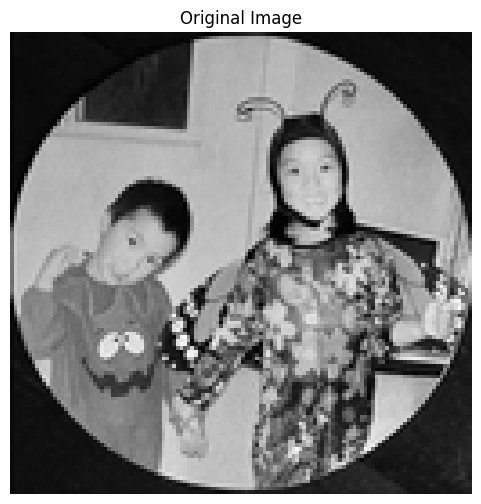

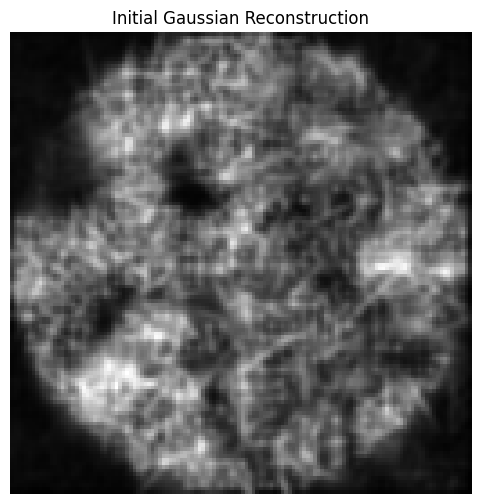

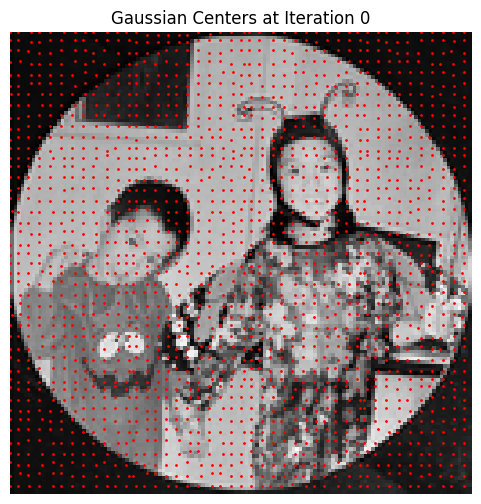

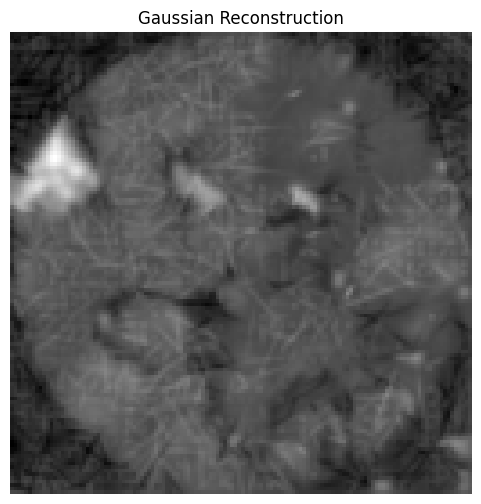

Iteration 1/100, Loss: 0.5672441720962524, LR: 0.4
Iteration 2/100, Loss: 0.20622974634170532, LR: 0.4
Iteration 3/100, Loss: 0.22628682851791382, LR: 0.4
Iteration 4/100, Loss: 0.21747234463691711, LR: 0.4
Iteration 5/100, Loss: 0.1950262486934662, LR: 0.4
Iteration 6/100, Loss: 0.17447683215141296, LR: 0.4
Iteration 7/100, Loss: 0.15225259959697723, LR: 0.4
Iteration 8/100, Loss: 0.13052192330360413, LR: 0.4
Iteration 9/100, Loss: 0.10879650712013245, LR: 0.4
Iteration 10/100, Loss: 0.08935779333114624, LR: 0.4


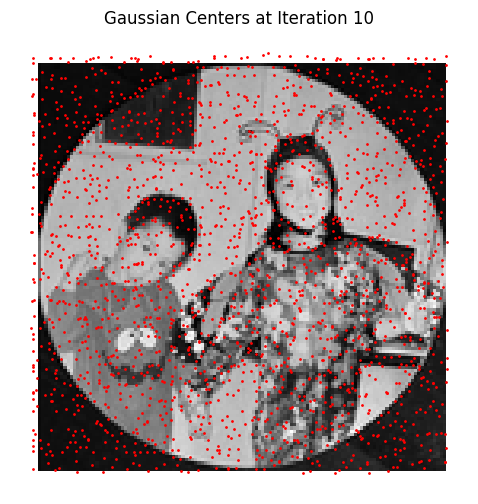

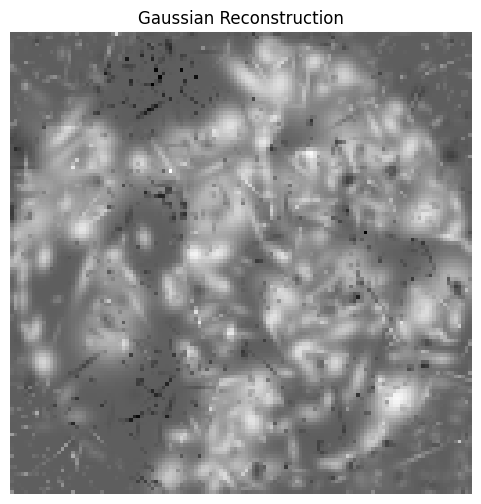

Iteration 11/100, Loss: 0.075197234749794, LR: 0.4
Iteration 12/100, Loss: 0.066428542137146, LR: 0.4
Iteration 13/100, Loss: 0.060494616627693176, LR: 0.4
Iteration 14/100, Loss: 0.055688537657260895, LR: 0.4
Iteration 15/100, Loss: 0.049687452614307404, LR: 0.4
Iteration 16/100, Loss: 0.04357152432203293, LR: 0.4
Iteration 17/100, Loss: 0.03937629237771034, LR: 0.4
Iteration 18/100, Loss: 0.034705132246017456, LR: 0.4
Iteration 19/100, Loss: 0.02972029708325863, LR: 0.4
Iteration 20/100, Loss: 0.026305828243494034, LR: 0.4


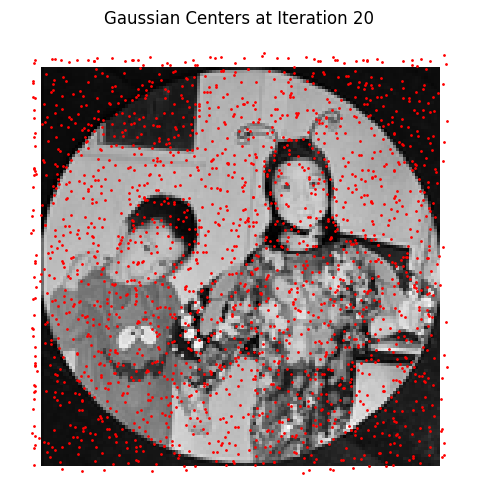

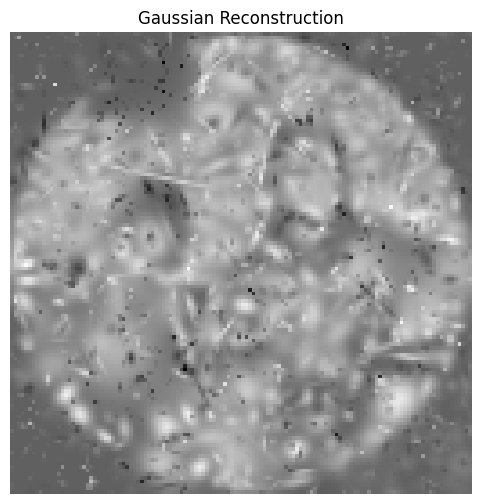

Iteration 21/100, Loss: 0.023815948516130447, LR: 0.4
Iteration 22/100, Loss: 0.02212006226181984, LR: 0.4
Iteration 23/100, Loss: 0.019878074526786804, LR: 0.4
Iteration 24/100, Loss: 0.018489202484488487, LR: 0.4
Iteration 25/100, Loss: 0.017030682414770126, LR: 0.4
Iteration 26/100, Loss: 0.015399141237139702, LR: 0.4
Iteration 27/100, Loss: 0.014227863401174545, LR: 0.4
Iteration 28/100, Loss: 0.013510891236364841, LR: 0.4
Iteration 29/100, Loss: 0.012711836025118828, LR: 0.4
Iteration 30/100, Loss: 0.012278256006538868, LR: 0.4


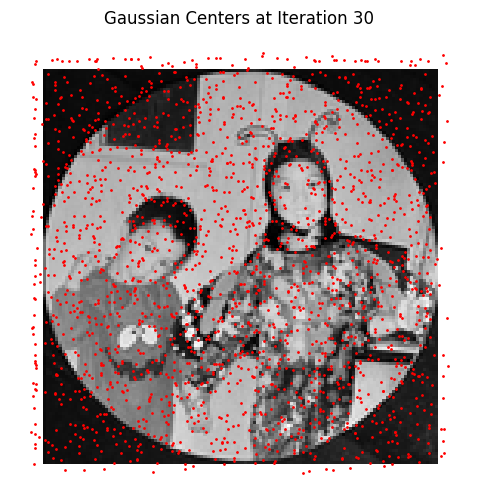

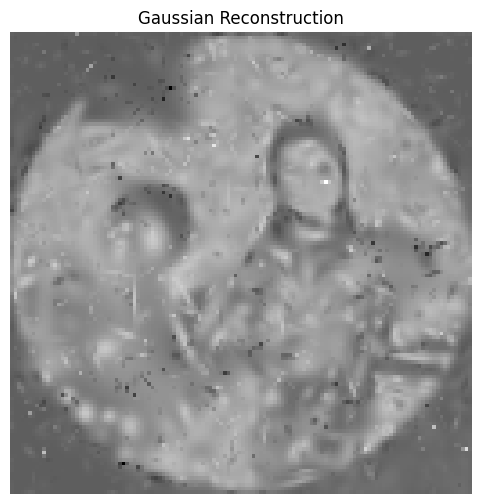

Iteration 31/100, Loss: 0.01193982269614935, LR: 0.4
Iteration 32/100, Loss: 0.011093830689787865, LR: 0.4
Iteration 33/100, Loss: 0.010492822155356407, LR: 0.4
Iteration 34/100, Loss: 0.010151214897632599, LR: 0.4
Iteration 35/100, Loss: 0.009670893661677837, LR: 0.4
Iteration 36/100, Loss: 0.009107626043260098, LR: 0.4
Iteration 37/100, Loss: 0.008675064891576767, LR: 0.4
Iteration 38/100, Loss: 0.008779617957770824, LR: 0.4
Iteration 39/100, Loss: 0.008599620312452316, LR: 0.4
Iteration 40/100, Loss: 0.00783941987901926, LR: 0.4


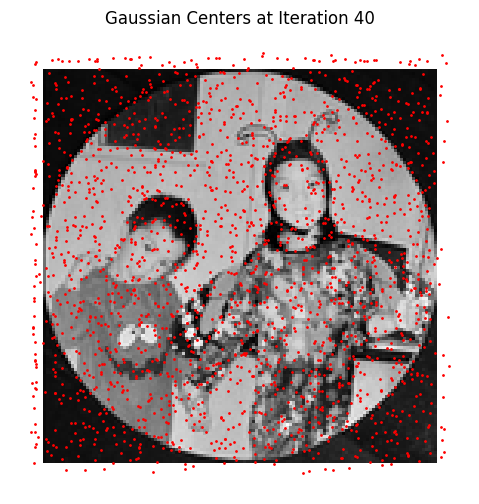

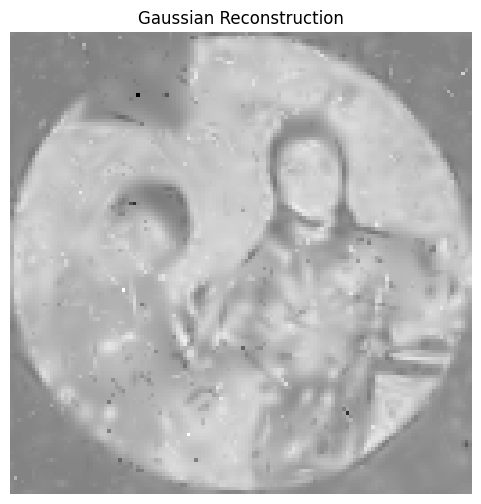

Iteration 41/100, Loss: 0.0070746587589383125, LR: 0.4
Iteration 42/100, Loss: 0.0072519732639193535, LR: 0.4
Iteration 43/100, Loss: 0.0069177523255348206, LR: 0.4
Iteration 44/100, Loss: 0.00673658587038517, LR: 0.4
Iteration 45/100, Loss: 0.0062734391540288925, LR: 0.4
Iteration 46/100, Loss: 0.006206699647009373, LR: 0.4
Iteration 47/100, Loss: 0.0056922356598079205, LR: 0.4
Iteration 48/100, Loss: 0.005353143438696861, LR: 0.4
Iteration 49/100, Loss: 0.005340696312487125, LR: 0.4
Iteration 50/100, Loss: 0.0049880752339959145, LR: 0.4


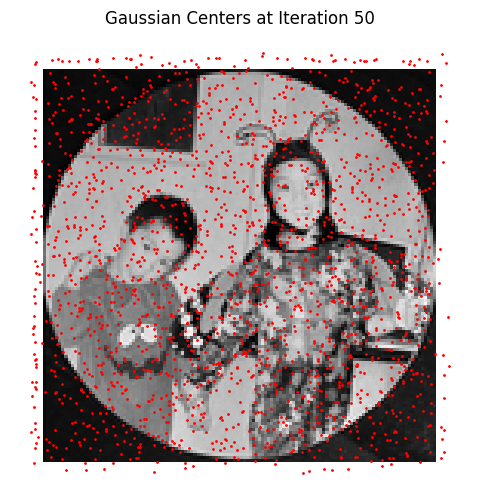

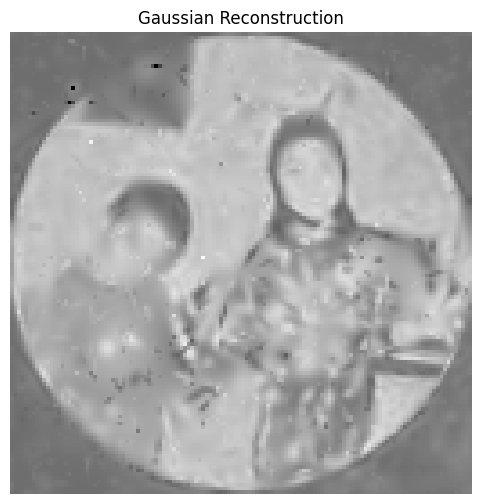

Iteration 51/100, Loss: 0.005005002487450838, LR: 0.4
Iteration 52/100, Loss: 0.004709081258624792, LR: 0.4
Iteration 53/100, Loss: 0.0045252032577991486, LR: 0.4
Iteration 54/100, Loss: 0.0042962683364748955, LR: 0.4
Iteration 55/100, Loss: 0.004203952383249998, LR: 0.4
Iteration 56/100, Loss: 0.003959595691412687, LR: 0.4
Iteration 57/100, Loss: 0.003842961508780718, LR: 0.4
Iteration 58/100, Loss: 0.003731105476617813, LR: 0.4
Iteration 59/100, Loss: 0.00364530342631042, LR: 0.4
Iteration 60/100, Loss: 0.0035345754586160183, LR: 0.4


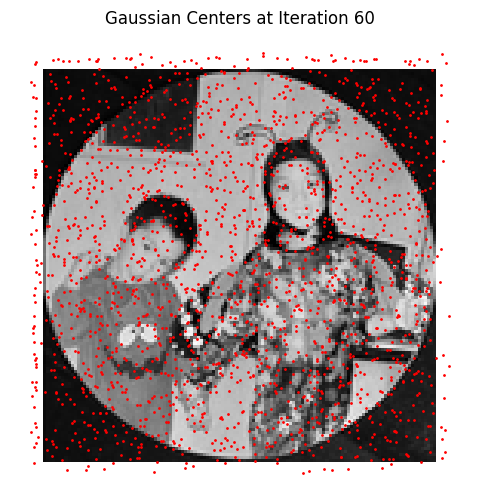

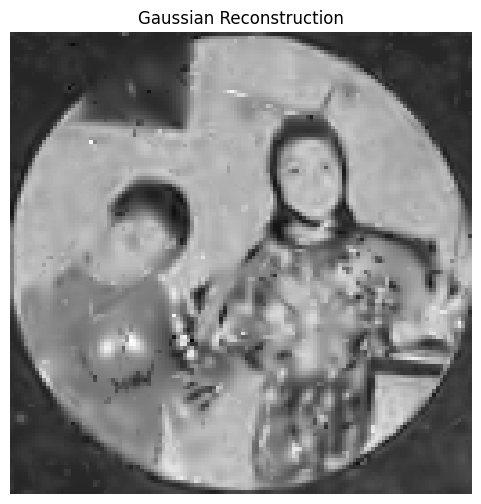

Iteration 61/100, Loss: 0.003410020377486944, LR: 0.4
Iteration 62/100, Loss: 0.003344387747347355, LR: 0.4
Iteration 63/100, Loss: 0.0032624080777168274, LR: 0.4
Iteration 64/100, Loss: 0.0031732337083667517, LR: 0.4
Iteration 65/100, Loss: 0.0030702133662998676, LR: 0.4
Iteration 66/100, Loss: 0.003049114951863885, LR: 0.4
Iteration 67/100, Loss: 0.0029138855170458555, LR: 0.4
Iteration 68/100, Loss: 0.0028730174526572227, LR: 0.4
Iteration 69/100, Loss: 0.002849061042070389, LR: 0.4
Iteration 70/100, Loss: 0.0028351428918540478, LR: 0.4


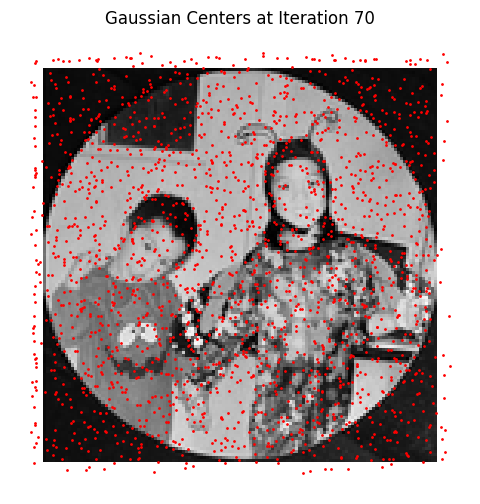

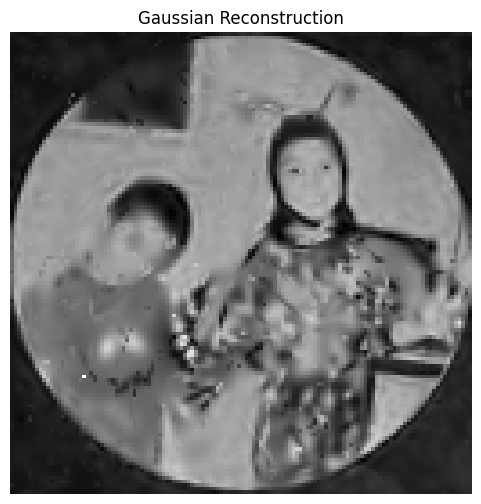

Iteration 71/100, Loss: 0.002754973480477929, LR: 0.4
Iteration 72/100, Loss: 0.0026645895559340715, LR: 0.4
Iteration 73/100, Loss: 0.0026630042120814323, LR: 0.4
Iteration 74/100, Loss: 0.0026297299191355705, LR: 0.4
Iteration 75/100, Loss: 0.00254898052662611, LR: 0.4
Iteration 76/100, Loss: 0.0025501034688204527, LR: 0.4
Iteration 77/100, Loss: 0.0025820815935730934, LR: 0.4
Iteration 78/100, Loss: 0.002513361629098654, LR: 0.4
Iteration 79/100, Loss: 0.002559941727668047, LR: 0.4
Iteration 80/100, Loss: 0.00247358251363039, LR: 0.4


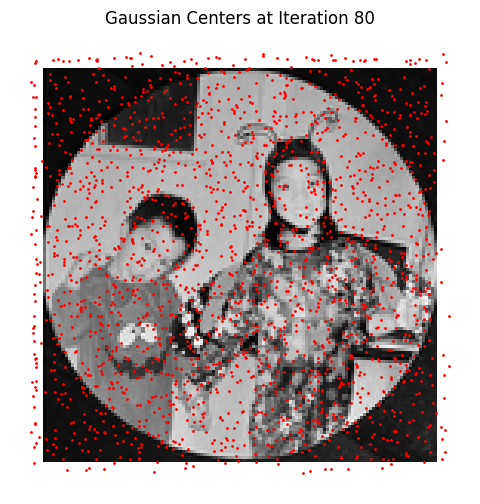

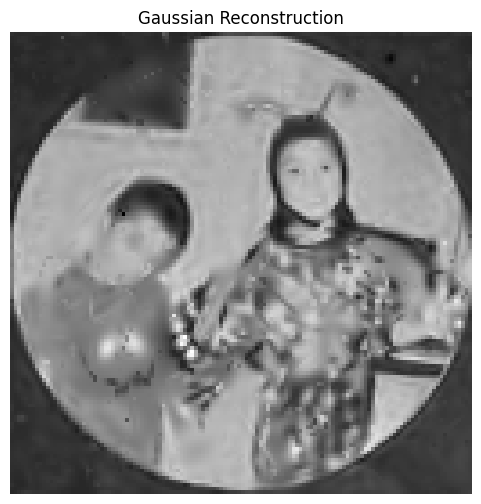

Iteration 81/100, Loss: 0.0023540202528238297, LR: 0.4
Iteration 82/100, Loss: 0.0023016096092760563, LR: 0.4
Iteration 83/100, Loss: 0.0022547319531440735, LR: 0.4
Iteration 84/100, Loss: 0.002276842948049307, LR: 0.4
Iteration 85/100, Loss: 0.0023683866020292044, LR: 0.4
Iteration 86/100, Loss: 0.0025726035237312317, LR: 0.4
Iteration 87/100, Loss: 0.003094685962423682, LR: 0.4
Iteration 88/100, Loss: 0.00355637283064425, LR: 0.4
Iteration 89/100, Loss: 0.0032780985347926617, LR: 0.4
Iteration 90/100, Loss: 0.0027775836642831564, LR: 0.4


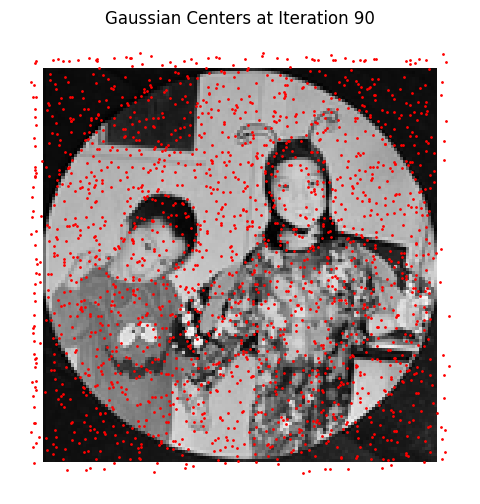

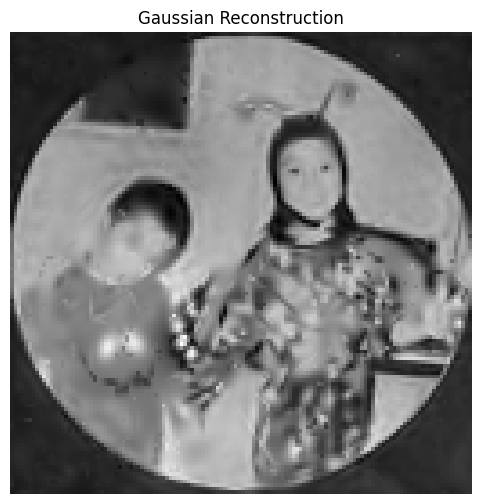

Iteration 91/100, Loss: 0.0027772290632128716, LR: 0.4
Iteration 92/100, Loss: 0.0030184818897396326, LR: 0.4
Iteration 93/100, Loss: 0.0026082410477101803, LR: 0.4
Iteration 94/100, Loss: 0.002451515756547451, LR: 0.4
Iteration 95/100, Loss: 0.0024138768203556538, LR: 0.4
Iteration 96/100, Loss: 0.0023258731234818697, LR: 0.4
Iteration 97/100, Loss: 0.0023214088287204504, LR: 0.4
Iteration 98/100, Loss: 0.0023144204169511795, LR: 0.4
Iteration 99/100, Loss: 0.0021822527050971985, LR: 0.4
Iteration 100/100, Loss: 0.0021948600187897682, LR: 0.27999999999999997


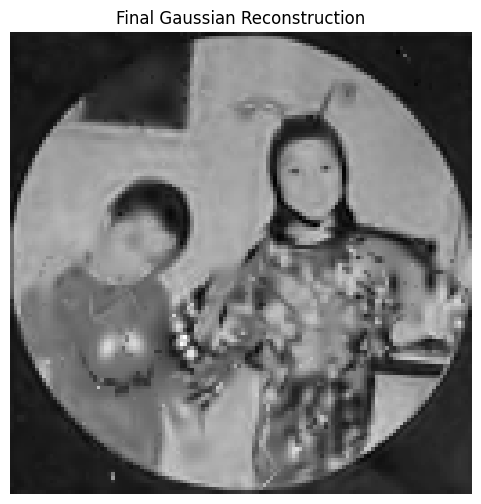

In [7]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and normalize the image
image_path = '/home/justin/Pictures/jyjy.jpg'
image = Image.open(image_path).convert('L')

desired_size = (128, 128)  # Desired resolution
image = image.resize(desired_size, Image.LANCZOS)

img_np = np.array(image) / 255.0
img_tensor = torch.tensor(img_np).float().cuda()

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Define the 2D Gaussian function with a color intensity parameter and rotation angle
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle):
    # Calculate the centered coordinates
    x_centered = x - mu_x
    y_centered = y - mu_y
    
    # Rotate the coordinates
    x_rot = x_centered * torch.cos(rotation_angle) - y_centered * torch.sin(rotation_angle)
    y_rot = x_centered * torch.sin(rotation_angle) + y_centered * torch.cos(rotation_angle)
    
    exponent = -((x_rot**2) / (2*sigma_x**2) + (y_rot**2) / (2*sigma_y**2))
    return (torch.exp(exponent)) * color_intensity

# Model the image using a set of rotated Gaussians
def model_image(params, shape):
    x = torch.linspace(0, shape[1] - 1, shape[1]).cuda()
    y = torch.linspace(0, shape[0] - 1, shape[0]).cuda()
    x, y = torch.meshgrid(x, y)
    model = torch.zeros_like(x)
    
    for i in range(0, len(params), 7): 
        mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle, _ = params[i:i+7]
        model += gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, color_intensity, rotation_angle)
    
    return model

# Mean squared error loss function
def mse_loss(params):
    model = model_image(params, img_tensor.shape)
    loss = torch.mean((model - img_tensor)**2)
    return loss

# Initialization using grid approach and sampling the image
num_gaussians = 2000
grid_size = int(np.sqrt(num_gaussians))
params = []
image_height, image_width = img_tensor.shape

for i in range(grid_size):
    for j in range(grid_size):
        # Calculate the coordinates within the image
        x_coord = (i * image_width) // grid_size
        y_coord = (j * image_height) // grid_size
        
        # Sample the color intensity from the image at the calculated coordinates
        color_intensity = img_tensor[y_coord, x_coord]
        # print(color_intensity)
        
        mu_x = torch.tensor(x_coord).float().cuda()
        mu_y = torch.tensor(y_coord).float().cuda()
        sigma_x = torch.randn(1).mul(2).add(1).clamp(1, 20).cuda()
        sigma_y = torch.randn(1).mul(2).add(1).clamp(1, 20).cuda()
        rotation_angle = torch.rand(1).mul(2 * np.pi).cuda()  # Random rotation angle
        
        params.extend([mu_x.item(), mu_y.item(), sigma_x.item(), sigma_y.item(), color_intensity.item(), rotation_angle.item(), 0.0])

params = torch.tensor(params, device='cuda').requires_grad_()
optimizer = optim.Adam([params], lr=0.4)  # Slightly increase learning rate to observe effects
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

# Display the initial Gaussian-based reconstruction
initial_model = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(initial_model, cmap='gray')
plt.title("Initial Gaussian Reconstruction")
plt.axis('off')
plt.show()

# Optimize with scheduler step
iterations = 100
display_interval = 10  # Display the Gaussian centers every 100 iterations

for iteration in range(iterations):
    optimizer.zero_grad()
    loss = mse_loss(params)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if iteration % display_interval == 0:
        # Display Gaussian centers intermittently
        plt.figure(figsize=(6, 6))
        plt.imshow(img_np, cmap='gray')
        plt.scatter(params[::7].cpu().detach().numpy(), params[1::7].cpu().detach().numpy(), color='red', s=1)
        plt.title(f"Gaussian Centers at Iteration {iteration}")
        plt.axis('off')
        plt.show()

        model = model_image(params, img_tensor.shape).cpu().detach().numpy()
        plt.figure(figsize=(6, 6))
        plt.imshow(model, cmap='gray')
        plt.title("Gaussian Reconstruction")
        plt.axis('off')
        plt.show()
    
    print(f"Iteration {iteration + 1}/{iterations}, Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

# Display result
result = model_image(params, img_tensor.shape).cpu().detach().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(result, cmap='gray')
plt.title("Final Gaussian Reconstruction")
plt.axis('off')
plt.show()